In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rootdir = '/local/data/bSOSE/'
niter = 'iter133NEW'
freq = '5day'
chunks = 1
# Load all carbon tendencies and fluxes
filenames = 'bsose_i133_2013to2018_5day_*C.nc'
ds = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load surface carbon flux
filenames = 'bsose_i133_2013to2018_5day_surfCO2flx.nc'
ds_surf = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load velocity data
filenames = 'bsose_i133_2013to2018_5day_*vel.nc'
ds_vel = xr.open_mfdataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
# Load carbon snapshots
filenames = 'bsose_i133_2013to2018_5daySnapShots_DIC.nc'
ds_snaps = xr.open_dataset(rootdir+niter+'/'+freq+'/'+filenames,chunks={'time':chunks})
ds_snaps = ds_snaps.rename({'time':'time_snaps','TRAC01':'TRAC01_snaps'}).drop('iter')

# Specify shift of time axis for snapshots
ds_snaps['time_snaps'].attrs['c_grid_axis_shift']=-0.5

# Merge to full dataset
ds = xr.merge([ds,ds_snaps,ds_vel,ds_surf])

# Define vertical metrics as negative, to account for descending coordinate
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point
# Volume
ds['vC'] = ds['drC']*ds['rA']
# Define cell side areas
ds['rAW'] = ds['dyG']*ds['drW']
ds['rAS'] = ds['dxG']*ds['drS']

# Define time metric
# HACK: trouble with time difference metric, so here just setting up own array with 5-days in seconds 
dt = xr.DataArray(432000*np.ones(shape=(438)),dims='time')
# Reference density
rho0 = 1035.0

metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

xgrid = Grid(ds,periodic=['X'],metrics=metrics)

In [4]:
# Define some masks
# Mask to set surface velocity point to zero
tmp = np.ones(len(ds['Zl']))
tmp[0]=0
maskZl = xr.DataArray(tmp,dims=['Zl'],coords={'Zl':ds['Zl']})

# Mask to set surface tracer point to one (everything else to zero)
tmp = np.ones(len(ds['Z']))
tmp[1:]=0
maskZ = xr.DataArray(tmp,dims=['Z'],coords={'Z':ds['Z']})

In [5]:
# Carbon cellwise budget
budget = xr.Dataset()

budget['TEND'] = xgrid.diff(ds['TRAC01_snaps'],'T')/dt

budget['ADV'] = -(xgrid.diff(ds['ADVxTr01'],'X')+
                  xgrid.diff(ds['ADVyTr01'],'Y',boundary='extend')+
                  (-1*xgrid.diff(ds['ADVrTr01'],'Z',boundary='extend')))/ds['vC']

# Don't fully understand this term yet, especially setting w to zero at the surface
# Not required to close cell-wise budget
budget['DIV'] = ds['TRAC01']*(xgrid.diff(ds['UVEL']*ds['rAW'],'X')+
                              xgrid.diff(ds['VVEL']*ds['rAS'],'Y',boundary='extend')+
                              (-1*xgrid.diff(ds['WVEL']*maskZl*ds['rA'],'Z',boundary='extend')))/ds['rA']

budget['DIFF'] = -(xgrid.diff(ds['DFxETr01'],'X')+
                  xgrid.diff(ds['DFyETr01'],'Y',boundary='extend')+
                  (-1*xgrid.diff(ds['DFrITr01'],'Z',boundary='extend')))/ds['vC']

budget['BIO'] = ds['BLGBIOC']


budget['SURF'] = maskZ*(ds['BLGCFLX']/ds['drC'])

budget['FORC'] = ds['ForcTr01']

# Corrects for vertical advection of carbon at z=0
budget['CORR'] = maskZ*ds['WTRAC01']/ds['drC']
budget['ADVcorr'] = budget['ADV'] - budget['CORR']

budget['RES'] = (-1*budget['TEND']+budget['ADVcorr']
                 +budget['DIFF']+budget['BIO']
                 +budget['FORC']+budget['SURF'])

In [6]:
signs = {'TEND':-1,'ADV':1,'ADVcorr':1,'DIV':1,'DIFF':1,'BIO':1,'FORC':1,'CORR':1,'SURF':1}

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/home/a

(-1e-11, 1e-11)

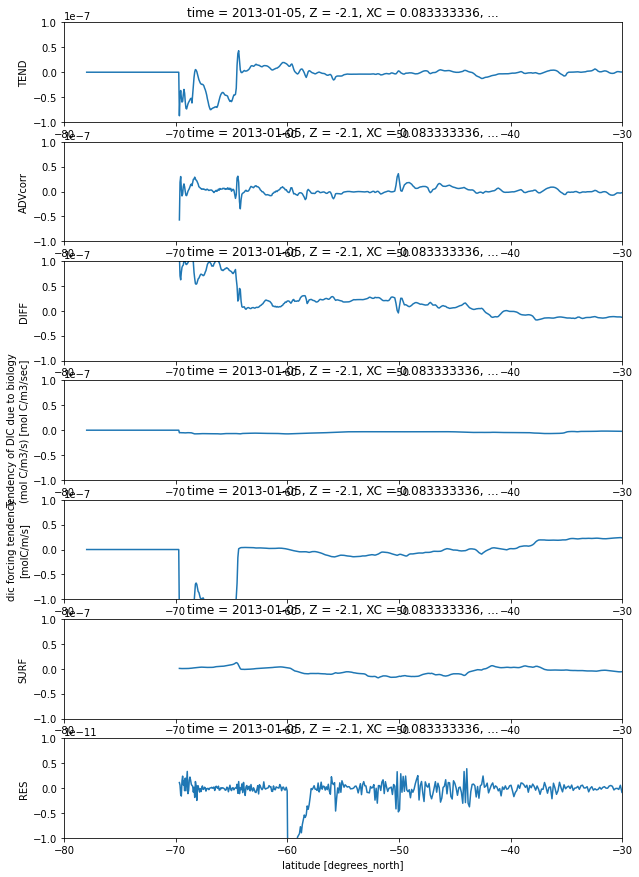

In [10]:
# terms = ['TEND','ADV','DIV','DIFF','BIO','FORC','CORR']
terms = ['TEND','ADVcorr','DIFF','BIO','FORC','SURF']
select = {'time':0,'XC':0,'Z':0}
fig,axarr=plt.subplots(figsize=(10,15),nrows=len(terms)+1)
RES = xr.zeros_like(budget[terms[0]].isel(select))
RES.name = 'RES'
for i,term in enumerate(terms):
    ax=axarr.flat[i]
    budget[term].isel(select).plot(ax=ax,label=term)
    ax.set_xlim([-80,-30])
    ax.set_ylim([-1E-7,1E-7])
    RES += signs[term]*budget[term].isel(select)
ax=axarr.flat[-1]    
RES.plot(ax=ax,label='RES')
ax.set_xlim([-80,-30])
ax.set_ylim([-1E-11,1E-11])
# plt.gca().legend()

/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aos/graemem/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/home/a

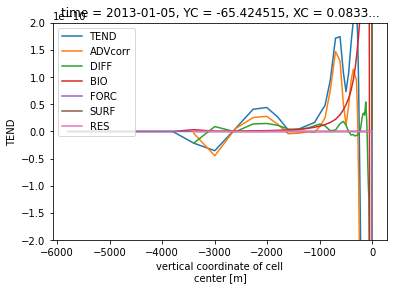

In [70]:
terms = ['TEND','ADVcorr','DIFF','BIO','FORC','SURF']
select = {'time':0,'XC':0,'YC':250}
RES = xr.zeros_like(budget[terms[0]].isel(select))
for term in terms:
    budget[term].isel(select).plot(label=term)
    RES += signs[term]*budget[term].isel(select)
RES.plot(label='RES')
# plt.gca().set_xlim([-80,-30])
plt.gca().set_ylim([-2E-10,2E-10])
plt.gca().legend()

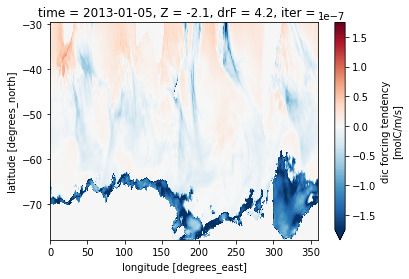

In [12]:
select = {'time':0,'Z':0}
budget['FORC'].isel(select).plot(robust=True)